In [1]:
import csv
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [3]:
import os
print("=== 범인 색출 ===")
print(os.getcwd())  # 현재 작업 경로 출력

=== 범인 색출 ===
c:\Users\sinji\Downloads\smart-gesture-control-system-main\smart-gesture-control-system-main


# Set number of classes

In [5]:
NUM_CLASSES = 6
# 구분해야하는 객체의 개수 설정

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
# 훈련용(75%)과 시험용(25%)으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),          # [입력층] 42개의 숫자가 들어옴
    tf.keras.layers.Dropout(0.2),               # [과적합 방지] 일부러 20% 정보를 잊게 만듦 (응용력 향상)
    tf.keras.layers.Dense(20, activation='relu'), # [은닉층] 20개의 뉴런으로 생각함
    tf.keras.layers.Dropout(0.4),               # [과적합 방지] 또 40%를 가림
    tf.keras.layers.Dense(10, activation='relu'), # [은닉층] 10개의 뉴런으로 요약함
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # [출력층] 최종 4개 중 확률 계산
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# 학습 설정 (채점 방식 등 정하기)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # 다중 분류 문제용 오답 채점표
    metrics=['accuracy'] # 정확도를 보겠다
)

# Model training

In [13]:
# 학습 시작!
model.fit(
    X_train, y_train,
    epochs=1000,      # 최대 1000번 반복 공부
    batch_size=128,   # 한 번에 128문제씩 풀기
    validation_data=(X_test, y_test), # 시험용 데이터로 중간 점검
    callbacks=[cp_callback, es_callback] # 성적 안 오르면 조기 종료(Early Stopping)
)

Epoch 1/1000
 1/37 [..............................] - ETA: 11s - loss: 1.9462 - accuracy: 0.1250
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 0s 4ms/step - loss: 1.8099 - accuracy: 0.1766 - val_loss: 1.7088 - val_accuracy: 0.2470
Epoch 2/1000
 1/37 [..............................] - ETA: 0s - loss: 1.7896 - accuracy: 0.1719
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 0s 2ms/step - loss: 1.7086 - accuracy: 0.2532 - val_loss: 1.6376 - val_accuracy: 0.3395
Epoch 3/1000
 1/37 [..............................] - ETA: 0s - loss: 1.6904 - accuracy: 0.2422
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
37/37 [==============================] - 0s 2ms/step - loss: 1.6418 - accuracy: 0.2855 - val_loss: 1.5776 - val_accuracy: 0.3407
Epoch 4/1000
 1/37 [..............................] - ETA: 0s - loss: 1.5697 - accuracy: 0.3438


In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 767us/step - loss: 0.3267 - accuracy: 0.9329


In [15]:
# Loading the saved model
import tensorflow as tf
import shutil
import os

# 1. 문제가 되는 원본 파일 경로 (한글 포함)
original_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 2. 임시로 복사할 안전한 경로 (D드라이브 최상단 루트)
#    (D:\temp_loader.hdf5 라는 이름으로 잠시 만듭니다)
temp_path = 'D:\\temp_loader.hdf5'

try:
    # [핵심] 파이썬의 shutil은 한글 경로를 잘 읽습니다.
    # 원본 파일을 D드라이브 맨 앞(영어 경로)으로 복사합니다.
    print(f"파일 복사 중... ({original_path} -> {temp_path})")
    shutil.copyfile(original_path, temp_path)
    
    # 3. 복사된 안전한 파일(영어 경로)을 로드합니다.
    print("모델 로드 시도...")
    model = tf.keras.models.load_model(temp_path)
    print("✅ 모델 로드 성공!")

except Exception as e:
    print("❌ 오류 발생:", e)

finally:
    # 4. 다 썼으면 빌려온 임시 파일 삭제 (뒷정리)
    if os.path.exists(temp_path):
        os.remove(temp_path)
        print("임시 파일 삭제 완료.")

파일 복사 중... (model/keypoint_classifier/keypoint_classifier.hdf5 -> D:\temp_loader.hdf5)
❌ 오류 발생: [Errno 2] No such file or directory: 'D:\\temp_loader.hdf5'


In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 48ms/step
[3.2030120e-02 5.0386868e-02 9.1342962e-01 8.3755564e-05 1.1317197e-03
 2.9379134e-03]
2


# Confusion matrix

50/50 [==============================] - 0s 469us/step


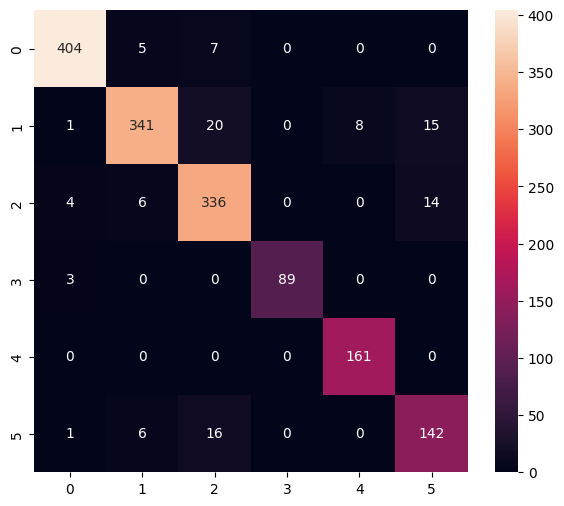

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       416
           1       0.95      0.89      0.92       385
           2       0.89      0.93      0.91       360
           3       1.00      0.97      0.98        92
           4       0.95      1.00      0.98       161
           5       0.83      0.86      0.85       165

    accuracy                           0.93      1579
   macro avg       0.93      0.94      0.93      1579
weighted avg       0.93      0.93      0.93      1579



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [19]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\sinji\AppData\Local\Temp\tmp467938z5\assets


INFO:tensorflow:Assets written to: C:\Users\sinji\AppData\Local\Temp\tmp467938z5\assets


6632

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.2030147e-02 5.0386861e-02 9.1342956e-01 8.3755644e-05 1.1317201e-03
 2.9379185e-03]
2
